# Straight line to real world


### TLDR:

A simple quadratic equation, or even basic linear regression, can be used to predict "real world" distance and trip duration using only the straight line distance between two points. The quality of the model will depend on geographical features.

### Introduction

When it comes to automate an logistics pipeline, depending on the scale or the algorithm being used, it's not always possible to query google for travel distance and time from a point A to a point B. In this cases, an approximation might work perfectly fine. This analysis is the tool to get to this approximation.

### What will be done ###

First, we will get location samples from the location of study. The next step is to pair thos samples and get the booth the straight line distance and the "real world" travel distance and duration. With these, we will try to find a model that can predict the "real world" variables using only the straight line distance.

## Let's beggin!

In [33]:
#Data visualization
import matplotlib.pyplot as plt
import folium

#Data cleaning and modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from regressors import stats
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np

#Google API
from googleplaces import GooglePlaces
import googlemaps

#Support functions
from time import sleep
from shapely.geometry import Point
import yaml

#No warnings
import warnings
warnings.filterwarnings("ignore")

#Open the config file
config = yaml.safe_load(open("config.yml"))

In [34]:
#Setup. It's all defined on the config.yml document

# Set our Google API Key and connect into google maps
google_places = GooglePlaces(config['google_api_key'])
gmaps = googlemaps.Client(key=config['google_api_key'])
#A little bit of setup
city = config['city']
lat = config['lat']
lng = config['lng']

### Random samples

The first step is to get a random sample of pairs of addresses from the desired location. For this, the Google Nearby Search API is the chosen tool. In this case, we will be analysing the city of São Paulo, Brazil.

In [35]:
#Making the request
query_result = google_places.text_search(
        query='Markets in {city}'.format(city=city))

#Dumping into a list
results = list()
for place in query_result.places:
    aux_dict = {'lat': place.geo_location['lat'],
                'lng': place.geo_location['lng'],
                'name': place.name}

    results.append(aux_dict)

#If there are more results, keep querying. It's set to query 5 times, for a maximum of 100 locations
for i in range(5):
    if (query_result.has_next_page_token):
        sleep(3)
        query_result = google_places.text_search(
            pagetoken=query_result.next_page_token)
        
        for place in query_result.places:
            aux_dict = {'lat': place.geo_location['lat'],
                        'lng': place.geo_location['lng'],
                        'name': place.name}
                        
            results.append(aux_dict)


With this sample, the number of possible pairs is (n*n-1)/2:

In [36]:
print("Number of locations: ", len(results))
print("Possible pairs: ", int(len(results)*(len(results)-1)/2))

Number of locations:  60
Possible pairs:  1770


Plotting the locations on a map, so we can better visualize what are we working with. The locations are not random, they are ranked by Google. Depending on the subject of study, it might be necessary to modify the query to get more heterogeneous data.

In [37]:
region_map = folium.Map(location=[lat, lng], zoom_start=12)

for i in results:
    folium.Marker([i['lat'], i['lng']]).add_to(region_map)

region_map

Now we will pair the locations. 

In [38]:
pairs = list()

#For every location, iterr with the remaining locations
for i in range(len(results)):
    for j in range(i+1, len(results)):
        point1 = Point(results[i]['lat'], results[i]['lng'])
        point2 = Point(results[j]['lat'], results[j]['lng'])
        #Distance between the points, in km
        straight_distance = point1.distance(point2) * 111.32

        aux_dict = {'point1': point1,
                    'point2': point2,
                     'straight_distance': straight_distance}

        pairs.append(aux_dict)   

#Turning into a dataframe
pairs = pd.DataFrame(data=pairs)

The data might need to be cleaned to ensure there is no points outside the city. First, a histogram will be plotted with the distribution of distances (in km) on the x axis, so we can se if there is the case.

<AxesSubplot:>

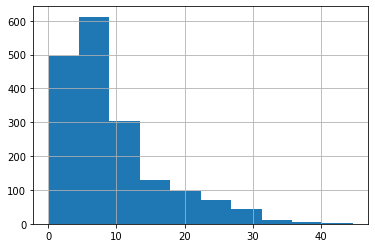

In [39]:
pairs['straight_distance'].hist()

Depending on the histogram, it might be necessary to clean the data. We will discart every pair with a distance greater than an arbitrary number of km, to drop outliers and out of town locations.

In [40]:
#pairs = pairs[pairs['straight_distance'] < 50]

The number of pairs might be unnecessarily big, costing when using the Distance Matrix API. So we will get a random sample within our sample, of 300 pairs.

In [41]:
print("There were {}. We will use only 300 of those.".format(len(pairs)))
sub_sample = pairs.sample(n=300)

There were 1770. We will use only 300 of those.


### Getting the real world data

It's time to get the real distance and time of the journey. For each pair, we will use the Distance Matrix API to get the predicted travel distance and duration from Google Maps.

In [42]:
#Suport lists
distance_maps = list()
travel_time = list()

#For every pair, we will get the travel distance and travel time
for i, pair in sub_sample.iterrows():
    
    route = gmaps.distance_matrix((pair['point1'].x, pair['point1'].y), (pair['point2'].x, pair['point2'].y), mode='driving')

    #Append to temporary lists
    distance_maps.append(route['rows'][0]["elements"][0]['distance']['value'])
    travel_time.append(route['rows'][0]["elements"][0]['duration']['value'])

#Add the data to the DataFrame
sub_sample['distance_maps'] = distance_maps
sub_sample['travel_time'] = travel_time


A little bit of data cleaning

In [43]:
#Distance from meters to kilometers
sub_sample['distance_maps'] = sub_sample['distance_maps']/1000
#Time from seconds to minutes
sub_sample['travel_time'] = sub_sample['travel_time']/60

### Analysing the data

With the data scraping and cleaning done, it's time to look at the data and find out if we can get that approximation we are looking for.

First, we will try some linear regression and see if the model fits well. We will be doing that for the following variables:

1. Straight distance and Google Maps distance

2. Straight distance and Google Maps trip duration

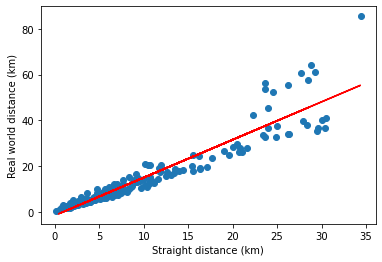

R²: 0.880
Standart deviation: 2.95


In [44]:
X = np.array(sub_sample['straight_distance']).reshape(-1, 1)
y = np.array(sub_sample['distance_maps']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor_1 = LinearRegression()
regressor_1.fit(X_train, y_train)

y_pred = regressor_1.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred, color ='red')

plt.xlabel("Straight distance (km)")
plt.ylabel("Real world distance (km)")
  
plt.show()
print("R²: %.3f" % regressor_1.score(X_test, y_test))
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

There is a very obvious (and predictable) relation between the straight line distance and the actual travel distance. A linear regression can catch this relation easily with an R&#178; of 0.90. This means we can already find an equation that takes care of this conversion. But, looking closely, there might be a non linear model that fits better the sample. Later we will try this solution. Now, let's try the same method for the travel time.

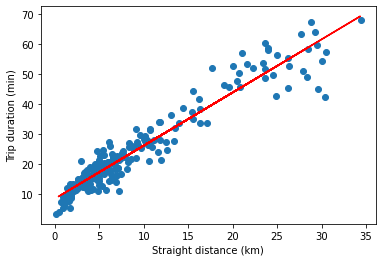

R²: 0.887
Standart deviation: 3.05


In [45]:
X = np.array(sub_sample['straight_distance']).reshape(-1, 1)
y = np.array(sub_sample['travel_time']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor_2 = LinearRegression()
regressor_2.fit(X_train, y_train)

y_pred = regressor_2.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred, color ='red')

plt.xlabel("Straight distance (km)")
plt.ylabel("Trip duration (min)")
  
plt.show()
print("R²: %.3f" % regressor_2.score(X_test, y_test))
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

The result is very similar to the last one. A linear regression fits quite nicely. But it can be done better with a non linear model. That's whats going to be done.

With the following function, we can take care of that over estimation that is occurring at the first few kilometers.

In [46]:
def func(x, a, b, c):
	return (a * x) + (b * x**2) + c

Let's apply the new model, fist to get the real world distance:

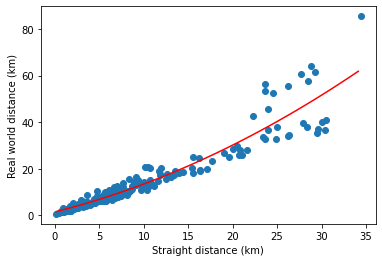

Standart deviation: 3.21


In [47]:
X = sub_sample['straight_distance']
y = sub_sample['distance_maps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

popt, pcov = curve_fit(func, X_train, y_train)

a, b, c = popt
plt.scatter(X_train, y_train)
x_line = np.arange(min(X_train), max(X_train), 1)
y_line = func(x_line, a, b, c)
plt.plot(x_line, y_line, color='red')

plt.xlabel("Straight distance (km)")
plt.ylabel("Real world distance (km)")

plt.show()

y_pred = func(X_test, *popt)
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

The model fits really well, all along the range. It's also an simple quadratic equation, so it's easy to implement and apply. The equation is the one that follows:

In [48]:
print('y =  %.5f + %.5fx + %.5fx²' % (c, a, b))

y =  1.48574 + 0.95974x + 0.02368x²


where y is the real world distance (in km) and x is the straight line distance (also in km).

Now let's see how the trip duration behaves:

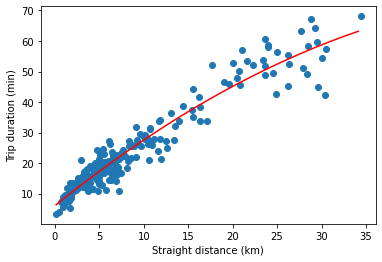

Standart deviation: 2.89


In [49]:
X = sub_sample['straight_distance']
y = sub_sample['travel_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

popt, pcov = curve_fit(func, X_train, y_train)

a, b, c = popt
plt.scatter(X_train, y_train)
x_line = np.arange(min(X_train), max(X_train), 1)
y_line = func(x_line, a, b, c)
plt.plot(x_line, y_line, color='red')


plt.xlabel("Straight distance (km)")
plt.ylabel("Trip duration (min)")

plt.show()

y_pred = func(X_test, *popt)
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

Also a great result. We can estimate the travel duration with the following equation:

In [50]:
print('y =  %.5f + %.5fx + %.5fx²' % (c, a, b))

y =  6.04891 + 2.35130x + -0.01986x²


where y is the travel duration (in minutes) and x is the straight line distance (in km).

## Where it might not work so well

São Paulo, used as an example, is a big city, without many "empty pockets" inside it. This means that there will not be montains to go around, or natural reserves, or other geographical features to mess with the results. Let's se how a city with this kind of geography behaves. We will repeat all the previous steps fo the city of Rio de Janeiro.

In [51]:
#Making the request
query_result = google_places.text_search(
        query='park in Rio de Janeiro')

#Dumping into a list
results = list()
for place in query_result.places:
    aux_dict = {'lat': place.geo_location['lat'],
                'lng': place.geo_location['lng'],
                'name': place.name}

    results.append(aux_dict)

#If there are more results, keep querying. It's set to query 5 times, for a maximum of 100 locations
for i in range(5):
    if (query_result.has_next_page_token):
        sleep(3)
        query_result = google_places.text_search(
            pagetoken=query_result.next_page_token)
        
        for place in query_result.places:
            aux_dict = {'lat': place.geo_location['lat'],
                        'lng': place.geo_location['lng'],
                        'name': place.name}
                        
            results.append(aux_dict)


In [52]:
region_map = folium.Map(location=['-22.9068', '-43.1729'], zoom_start=11)

for i in results:
    folium.Marker([i['lat'], i['lng']]).add_to(region_map)

region_map

In [53]:
pairs = list()

#For every location, iterr with the remaining locations
for i in range(len(results)):
    for j in range(i+1, len(results)):
        point1 = Point(results[i]['lat'], results[i]['lng'])
        point2 = Point(results[j]['lat'], results[j]['lng'])
        #Distance between the points, in km
        straight_distance = point1.distance(point2) * 111.32

        aux_dict = {'point1': point1,
                    'point2': point2,
                     'straight_distance': straight_distance}

        pairs.append(aux_dict)   

#Turning into a dataframe
pairs = pd.DataFrame(data=pairs)

<AxesSubplot:>

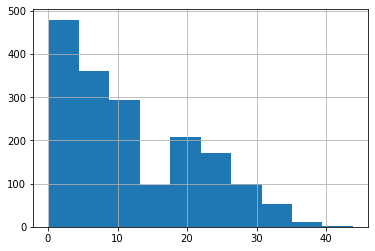

In [54]:
pairs['straight_distance'].hist()

Some close pairs will be dropped, as the locations are not as heterogeneous as in the previous city.

<AxesSubplot:>

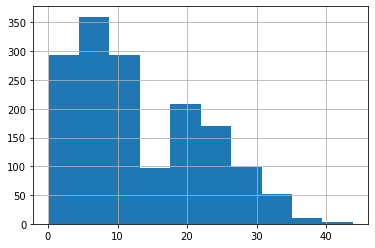

In [55]:
pairs = pairs.drop(pairs[pairs['straight_distance'] < 3].sample(frac=.5).index)

pairs['straight_distance'].hist()

In [56]:
print("There were {}. We will use only 300 of those.".format(len(pairs)))
sub_sample = pairs.sample(n=300)

There were 1585. We will use only 300 of those.


In [57]:
#Suport lists
distance_maps = list()
travel_time = list()

#For every pair, we will get the travel distance and travel time
for i, pair in sub_sample.iterrows():
    
    route = gmaps.distance_matrix((pair['point1'].x, pair['point1'].y), (pair['point2'].x, pair['point2'].y), mode='driving')

    #Append to temporary lists
    distance_maps.append(route['rows'][0]["elements"][0]['distance']['value'])
    travel_time.append(route['rows'][0]["elements"][0]['duration']['value'])

#Add the data to the DataFrame
sub_sample['distance_maps'] = distance_maps
sub_sample['travel_time'] = travel_time


In [58]:
#Distance from meters to kilometers
sub_sample['distance_maps'] = sub_sample['distance_maps']/1000
#Time from seconds to minutes
sub_sample['travel_time'] = sub_sample['travel_time']/60

Now we can plot the same graphs as before, and see if there are problemas because of the city's geography.

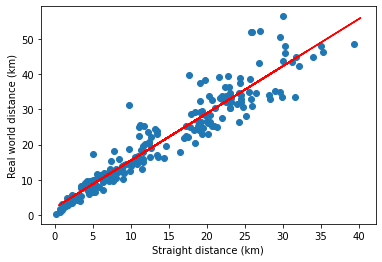

R²: 0.836
Standart deviation: 3.97


In [59]:
X = np.array(sub_sample['straight_distance']).reshape(-1, 1)
y = np.array(sub_sample['distance_maps']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor_1 = LinearRegression()
regressor_1.fit(X_train, y_train)

y_pred = regressor_1.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred, color ='red')

plt.xlabel("Straight distance (km)")
plt.ylabel("Real world distance (km)")
  
plt.show()
print("R²: %.3f" % regressor_1.score(X_test, y_test))
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

Interesting enough, the terrain does not affect much the conversion from straight line distance to real world distance. Booth the R squared and standard deviation are similar to the ones in São Paulo. Not only that, but a linear regression model fits the data very well.

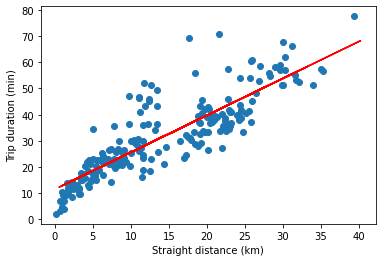

R²: 0.586
Standart deviation: 7.67


In [60]:
X = np.array(sub_sample['straight_distance']).reshape(-1, 1)
y = np.array(sub_sample['travel_time']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor_2 = LinearRegression()
regressor_2.fit(X_train, y_train)

y_pred = regressor_2.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred, color ='red')

plt.xlabel("Straight distance (km)")
plt.ylabel("Trip duration (min)")
  
plt.show()
print("R²: %.3f" % regressor_2.score(X_test, y_test))
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

On the other hand, the trip duration does have a low R squared, and double the standard deviation. We will try to improve with a non linear model:

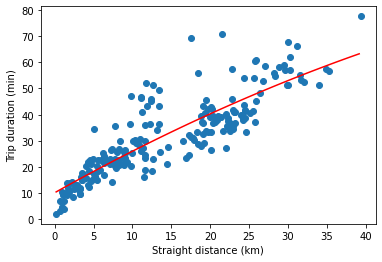

Standart deviation: 7.56


In [61]:
X = sub_sample['straight_distance']
y = sub_sample['travel_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

popt, pcov = curve_fit(func, X_train, y_train)

a, b, c = popt
plt.scatter(X_train, y_train)
x_line = np.arange(min(X_train), max(X_train), 1)
y_line = func(x_line, a, b, c)
plt.plot(x_line, y_line, color='red')


plt.xlabel("Straight distance (km)")
plt.ylabel("Trip duration (min)")

plt.show()

y_pred = func(X_test, *popt)
print("Standart deviation: %.2f" % np.sqrt(np.var(np.abs(y_test - y_pred))))

The improvement is there, but no where near enough to make reliable predictions. This is caused by those locations way above the curve, that in many cities could be considered outliers, but here are not abnormal.

## Conclusions

It is possible to extrapolate the straight line distance between two points to get an approximation to the real world distance, as well as the time needed to complet the trip. With a simple quadratic expression, or in some cases even a linear regression, it's possible to predict this information with reasonable success. The quality of the prediction will vary according to the city being studied, with peculiar geographical features making the model less reliable.

## Disclaimers

This analysis is not universal, the equations will change depending on the city, as well as the quality of the output.

The time of the day that the analysis is executed, as weel day of the week and other sazonal features, will result in different outputs.